<a href="https://colab.research.google.com/github/jcdumlao14/ESS11DataAnalysis/blob/main/Counterfactual_Causal_ML_(ATE_%2B_HTE)2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Counterfactual  Causal Machine Learning Analysis (Average Treatment Effect (ATE) +  Heterogeneous Treatment Effect (HTE))**

# **I. Goal**
- Investigate **"What-if"** scenarios: How would **predicted Cardiovascular Disease (CVD)** risk change in European populations if specific risk factor profiles were altered (target changes)?

# **II. Data Preparation**

- A. **Outcome Variable (Y)**: Binary CVD Indicator
   - Primary Variables (to create CVD outcome):
     - **hltprhc**: Health problems, last 12 months: heart or circulation problem
     - **hltphhc**: Health problems, hampered, last 12 month: heart or circulation problem (Hampered in daily activities due to heart issues)
  - Note: Prioritize the most specific indicator. If longitudinal data is available, aim for incident CVD. If not, be aware of potential reverse causation and collider bias.
Possible Additional/Supporting Covariates:**hltprhb, hltprdi**

- B. **Treatment/Target Change (W)**: Scenario-Specific.
   - **Scenario 1: Low Mortality Country Lifestyle**:
     - **Objective**: To model the effect of shifting a population to a lifestyle profile similar to that of a low-CVD mortality country.
     - **Method**: You reweight or replace X to match target distribution by variables.
       - **Target Change Variables**: (The "W" set to be altered to define the scenario.)
          - **cgtsmok**: Cigarette smoking behaviour
          - **alcfreq**: How often drink alcohol
          - **etfruit**: How often eat fruit, excluding drinking juice
          - eatveg: How often eat vegetables or salad, excluding potatoes
          - **dosprt**: Do sports or other physical activity, how many of last 7 days
          - **BMI**: Body Mass Index (calculated from height and weight).

   - **Scenario 2: Changing Specific Risk Factors**
      - **Objective**: To only affect smoking (e.g. cgtsmok to target a lower prevalence of heavy smoking)
- C. **Covariates (X)**: Control Variables
   - **Demographics**:
      - **agea**: Age of respondent, calculated
      - **gndr**: Gender
      - **Education**:edulvlb or country-specific.
   - **Country controls**:cntry
   - **Migration and Socio-economic Variables**: imsmetn ,imdfetn, impcntr
   - **Subjective variables to avoid the effect of it**: lrscale,polintr, stflife
   - **Weights** (Crucial to include for representativeness):
      - **dweight**: Design weight
      - **pspwght**: Post-stratification weight including design weight
     - **pweight**: Population size weight (if using, must be combined with dweight or pspwght)

 - **Region**:region

**III. Methods**(at least two)
- **Primary**: Causal Forest (Python, econml/causalml. Use CausalForestDML).
- **Robustness Check**: TMLE or **Double Machine Learning** (DML) - check that the result is the same in general to be robust.

*References*: EconML- **CausalForestDML** - https://www.pywhy.org/EconML/_autosummary/econml.dml.CausalForestDML.html

**IV. Estimation Tasks**
- **ATE**: Average Treatment Effect (of the specified intervention) with 90% and 95% Confidence Intervals.
- **ATT**: Average Treatment Effect on the Treated (if the intervention is only applied to a subset) with 90% and 95% Confidence Intervals.
- **HTE/CATE**: Heterogeneous Treatment Effects / Conditional Average Treatment Effect by Subgroups:
  - **Age Groups** (e.g., 18-29, 30-49, 50+).
  - **Sex** (Male, Female).
  - **Education** (Low, Medium, High - based on edulvlb or similar).
  - **Region** (e.g., East, West, North, South Europe - Requires creating a region variable based on cntry).

*References* **CATE**: https://www.pywhy.org/EconML/reference.html#instrumental-variable-cate-estimators

**V. Model Validation & Sensitivity**
- **A. Model Specification**: Vary tree depth and regularization parameters in the causal forest to assess stability.
- **B. Alternative Target Distributions**: Try different scenarios in "W." Examples:
   - Only change cgtsmok (smoking behavior) to a target distribution.
   - Change both cgtsmok and BMI to target distributions.
- **C. E-value for Unmeasured Confounding**: (For interpretation).
- **D. Weighted vs. Unweighted Analyses:**

**VI. Outputs**
- **tables/ate_scenarios.csv**:
   - Columns: Scenario Name, ATE (point estimate), Standard Deviation of ATE, 90% CI Lower, 90% CI Upper, 95% CI Lower, 95% CI Upper, Sample Size.
- **fig_forest_ate.png**: Forest plot displaying ATE estimates and CIs across different scenarios.
- **fig_cate_heatmap.png**: Heatmap showing CATE estimates for combinations of age groups and education levels.
- **tables/feature_importance_SHAP.csv**: Table with variables ranked by SHAP importance scores (remembering the caveats about interpreting SHAP values from a surrogate model).

# **Installing Independence**

In [1]:
!pip install econml

Data loaded. N = 662 CVD prevalence = 0.1284
econml is available. You can run CausalForestDML below for advanced estimation (honest forests).
Scenario 'baseline' took 0.00 seconds
Scenario 'bmi_to_25' took 1.70 seconds
Scenario 'reduce_heavy_smoking' took 1.49 seconds
Scenario 'bmi25_and_reduce_smoke' took 0.91 seconds
Scenario 'low_mortality_lifestyle' took 0.93 seconds

Saved ATE table to /content/ess_causal_outputs/tables/ate_scenarios.csv
Saved forest plot to /content/ess_causal_outputs/fig_forest_ate.png
Saved CATE heatmap to /content/ess_causal_outputs/fig_cate_heatmap.png
Saved feature importance (SHAP surrogate) to /content/ess_causal_outputs/tables/feature_importance_SHAP.csv

Done. Outputs saved in /content/ess_causal_outputs
Total runtime: 13.36 seconds
{'ate_csv': '/content/ess_causal_outputs/tables/ate_scenarios.csv', 'fig_forest_ate': '/content/ess_causal_outputs/fig_forest_ate.png', 'fig_cate_heatmap': '/content/ess_causal_outputs/fig_cate_heatmap.png', 'feature_importan

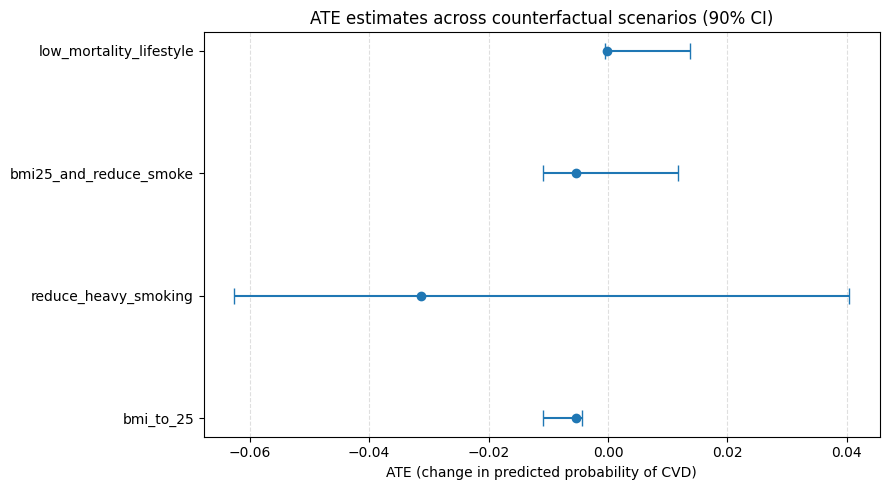

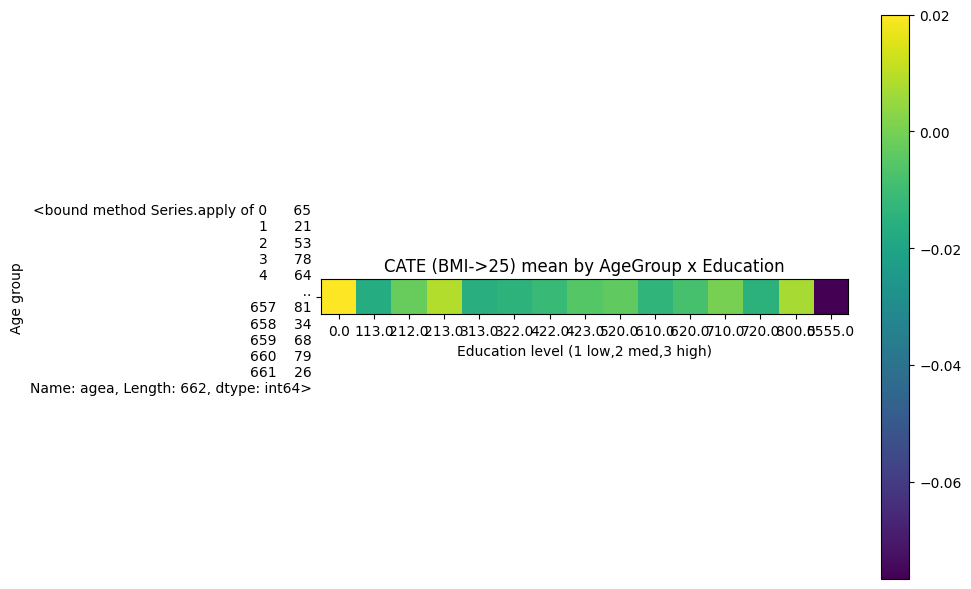

In [3]:
import os
import warnings
#warnings.filterwarnings("ignore")  # Remove during debugging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import time # Import time module

# Set random seed for reproducibility
np.random.seed(123)

# ---------
# Settings
# ----------

CSV_PATH = '/content/ESS11.csv'

# Output directory
OUT_DIR = '/content/ess_causal_outputs'
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, 'tables'), exist_ok=True)

# --- ADJUST THESE VALUES AS NEEDED ---
N_BOOTSTRAP = 5
RF_TREES = 50
RF_TREES_SMALL = 25


N_JOBS = -1       # Use all cores

# ----------------------
# European region mapping
# ----------------------
REGION_MAP = {
    'NO':'North','SE':'North','DK':'North','FI':'North','IS':'North','GB':'North','IE':'North',
    'FR':'West','BE':'West','NL':'West','LU':'West','DE':'West','AT':'West',
    'ES':'South','PT':'South','IT':'South','GR':'South','CY':'South','MT':'South',
    'PL':'East','CZ':'East','SK':'East','HU':'East','RO':'East','BG':'East','SI':'East','HR':'East',
    # add more if needed
}

def get_region(code):
    if pd.isna(code):
        return 'Unknown'
    c = str(code).strip().upper()
    return REGION_MAP.get(c, 'Unknown')

# ----------------------
# Helpers: loading and preprocessing
# ----------------------

def load_and_prepare(csv_path=None, verbose=True):
    """Load ESS11-like CSV if provided, else simulate demo data. Returns prepared DataFrame.
    The function attempts to build the outcome CVD from `hltprhc` (primary) or `hltphhc`.
    """
    if csv_path is None or not os.path.exists(csv_path):
        if verbose:
            print('CSV_PATH not provided or file not found. Running on simulated demo data.')
        return simulate_demo()

    usecols = None
    # recommended columns. If your CSV has different names, adjust below.
    key_cols = ['idno','cntry','dweight','pspwght','weighta','height','hltprhc','hltphhc',
                'etfruit','eatveg','dosprt','cgtsmok','alcfreq','alcwkdy','alcwknd','edulvlb','hinctnta','agea','gndr']
    try:
        df = pd.read_csv(csv_path, usecols=lambda c: True if c in key_cols else False, low_memory=False)
    except Exception as e:
        print('Error reading CSV; falling back to full read. Error:', e)
        df = pd.read_csv(csv_path, low_memory=False)

    # Ensure columns exist; create missing columns with NA
    for c in key_cols:
        if c not in df.columns:
            df[c] = np.nan

    # Outcome: prefer hltprhc, fallback to hltphhc
    # Convert common truthy values to 1 else 0; user may need to adapt mapping
    def map_binary(x):
        if pd.isna(x):
            return np.nan
        s = str(x).strip().lower()
        if s in ['1','yes','y','true','t','a','b','c']:
            return 1
        # numeric >=1 often indicates presence; adapt depending on coding
        try:
            vx = float(s)
            return 1 if vx >= 1 else 0
        except Exception:
            return 0

    if 'hltprhc' in df.columns and df['hltprhc'].notna().sum() > 0:
        df['CVD'] = df['hltprhc'].apply(map_binary)
    elif 'hltphhc' in df.columns and df['hltphhc'].notna().sum() > 0:
        df['CVD'] = df['hltphhc'].apply(map_binary)
    else:
        print('Warning: no heart problem outcome found in file. Creating simulated proxy for demo purposes.')
        df = df.sample(n=min(3000,len(df)), random_state=123).reset_index(drop=True)
        return simulate_demo(n=len(df))

    # BMI calculation
    df['height_m'] = df['height'] / 100.0
    df['BMI'] = df['weighta'] / (df['height_m'] ** 2)

    # Smoking: ensure coded categories 0-3; if strings, try to map;
    # Create heavy smoking indicator
    try:
        df['cgtsmok'] = pd.to_numeric(df['cgtsmok'], errors='coerce')
    except Exception:
        pass
    df['smoke_heavy'] = (df['cgtsmok'] == 3).astype(int)

    # Map region
    df['cntry'] = df['cntry'].astype(str)
    df['region'] = df['cntry'].apply(get_region)

    # Clean age & gender & education
    df['agea'] = pd.to_numeric(df['agea'], errors='coerce')
    df['gndr'] = pd.to_numeric(df['gndr'], errors='coerce')
    df['edulvlb'] = pd.to_numeric(df['edulvlb'], errors='coerce')

    # Keep only rows with essential fields
    essential = ['CVD','BMI','agea','gndr','edulvlb']
    df = df.dropna(subset=essential)

    return df.reset_index(drop=True)


def simulate_demo(n=3000):
    """Simulate an ESS-like dataset for demonstrations and development/testing.
    Returns DataFrame with necessary columns.
    """
    rng = np.random.RandomState(123)
    countries = list(REGION_MAP.keys()) + ['EE','LV','LT','CH','RS','BA']
    df = pd.DataFrame({
        'idno': np.arange(n),
        'cntry': rng.choice(countries, size=n),
        'agea': rng.randint(18, 90, size=n),
        'gndr': rng.choice([1,2], size=n, p=[0.48,0.52]),
        'edulvlb': rng.choice([1,2,3], size=n, p=[0.3,0.45,0.25]),
    })
    df['weighta'] = np.clip(rng.normal(78, 15, size=n), 45, 160)
    df['height'] = np.clip(rng.normal(170, 9, size=n), 140, 210)
    df['height_m'] = df['height'] / 100.0
    df['BMI'] = (df['weighta'] / (df['height_m']**2)).round(2)
    # smoking distribution varies by region
    def sample_smoke(r):
        p_map = { 'North':[0.50,0.20,0.20,0.10],'West':[0.45,0.20,0.25,0.10],'South':[0.40,0.20,0.25,0.15],'East':[0.35,0.20,0.25,0.20] }
        p = p_map.get(REGION_MAP.get(r,'West'), [0.45,0.20,0.20,0.15])
        return rng.choice([0,1,2,3], p=p)
    df['region'] = df['cntry'].apply(lambda c: get_region(c))
    df['cgtsmok'] = df['region'].apply(sample_smoke)
    df['etfruit'] = rng.randint(0,8,size=n)
    df['eatveg'] = rng.randint(0,8,size=n)
    df['dosprt'] = rng.randint(0,8,size=n)
    df['alcfreq'] = rng.choice([0,1,2,3], size=n, p=[0.25,0.35,0.30,0.10])
    df['alcwkdy'] = rng.randint(0,4,size=n)
    df['alcwknd'] = rng.randint(0,4,size=n)
    df['hinctnta'] = np.clip(rng.lognormal(10, 0.5, size=n), 500, 200000)
    df['dweight'] = rng.uniform(0.5, 2.5, size=n)
    df['pspwght'] = df['dweight'] * rng.uniform(0.8, 1.2, size=n)
    # generate CVD probability
    logit = (
        -6.5
        + 0.05 * df['agea']
        + 0.6 * (df['cgtsmok'] == 3).astype(int)
        + 0.02 * (df['BMI'] - 25).clip(-10, 20)
        - 0.06 * df['dosprt']
        + 0.15 * (df['gndr'] == 1).astype(int)
        - 0.12 * (df['edulvlb'] == 3).astype(int)
    )
    p = 1 / (1 + np.exp(-logit))
    df['CVD'] = (rng.rand(n) < p).astype(int)
    df['smoke_heavy'] = (df['cgtsmok'] == 3).astype(int)
    return df

# ----------------------
# Scenario definitions
# ----------------------

def scenario_bmi_target(df_in, target_bmi=25.0):
    df2 = df_in.copy()
    df2['BMI'] = target_bmi
    return df2


def scenario_reduce_smoking(df_in, heavy_prob_target=0.05, random_state=123):
    df2 = df_in.copy()
    cur = df2['smoke_heavy'].mean()
    if heavy_prob_target >= cur or cur == 0:
        return df2
    reduce_fraction = (cur - heavy_prob_target) / cur
    heavy_idx = df2[df2['smoke_heavy'] == 1].index
    rng = np.random.RandomState(random_state)
    n_change = int(reduce_fraction * len(heavy_idx))
    if n_change <= 0:
        return df2
    change_idx = rng.choice(heavy_idx, size=n_change, replace=False)
    df2.loc[change_idx, 'cgtsmok'] = 2
    df2.loc[change_idx, 'smoke_heavy'] = 0
    return df2


def scenario_low_mortality_lifestyle(df_in):
    df2 = df_in.copy()
    df2 = scenario_reduce_smoking(df2, heavy_prob_target=0.05)
    df2['etfruit'] = np.minimum(7, df2['etfruit'] + np.random.randint(1,3,size=len(df2)))
    df2['eatveg'] = np.minimum(7, df2['eatveg'] + np.random.randint(1,3,size=len(df2)))
    df2['dosprt'] = np.minimum(7, df2['dosprt'] + np.random.randint(1,3,size=len(df2)))
    df2['BMI'] = np.clip(df2['BMI'] - 1.2, 10, 60)
    return df2

SCENARIOS = {
    'baseline': lambda d: d.copy(),
    'bmi_to_25': lambda d: scenario_bmi_target(d, 25.0),
    'reduce_heavy_smoking': lambda d: scenario_reduce_smoking(d, heavy_prob_target=0.05),
    'bmi25_and_reduce_smoke': lambda d: scenario_reduce_smoking(scenario_bmi_target(d,25.0), heavy_prob_target=0.05),
    'low_mortality_lifestyle': lambda d: scenario_low_mortality_lifestyle(d),
}

# ----------------------
# Estimators & inference helpers
# ----------------------

def estimate_ate_by_outcome_model_replacement(df, features=None, outcome_col='CVD', target_bmi=25.0, n_boot=100):
    """Outcome model (T->continuous) replacement ATE estimator.
    Fit P(Y|X,BMI) then replace BMI->target and compute mean(pred_cf - pred_base).
    Bootstrapped refits used for CI estimation.
    """
    if features is None:
        features = ['agea','gndr','edulvlb','BMI','cgtsmok','etfruit','eatveg','dosprt','alcfreq','hinctnta']
    X = df[features].copy()
    X_enc = pd.get_dummies(X, columns=['gndr','edulvlb','cgtsmok','alcfreq'], drop_first=True)
    y = df[outcome_col].values

    model = RandomForestClassifier(n_estimators=RF_TREES, random_state=123, n_jobs=N_JOBS)
    model.fit(X_enc, y)
    pred_base = model.predict_proba(X_enc)[:,1]

    X_mod = X.copy(); X_mod['BMI'] = target_bmi
    X_mod_enc = pd.get_dummies(X_mod, columns=['gndr','edulvlb','cgtsmok','alcfreq'], drop_first=True)
    for c in X_enc.columns:
        if c not in X_mod_enc.columns:
            X_mod_enc[c] = 0
    X_mod_enc = X_mod_enc[X_enc.columns]
    pred_cf = model.predict_proba(X_mod_enc)[:,1]
    ate_point = (pred_cf - pred_base).mean()

    # bootstrap
    ate_boot = []
    n = len(df)
    for i in range(n_boot):
        idx = np.random.choice(n, n, replace=True)
        Xb = X_enc.iloc[idx]; yb = y[idx]
        mb = RandomForestClassifier(n_estimators=RF_TREES_SMALL, random_state=1000+i, n_jobs=N_JOBS)
        try:
            mb.fit(Xb, yb)
        except Exception:
            continue
        pred_base_b = mb.predict_proba(Xb)[:,1]
        X_mod_b = X_mod_enc.iloc[idx]
        pred_cf_b = mb.predict_proba(X_mod_b)[:,1]
        ate_boot.append((pred_cf_b - pred_base_b).mean())
    ate_boot = np.array(ate_boot)
    ate_std = np.nan if len(ate_boot) == 0 else ate_boot.std(ddof=1)
    lower_90 = np.nan if len(ate_boot) == 0 else np.percentile(ate_boot, 5)
    upper_90 = np.nan if len(ate_boot) == 0 else np.percentile(ate_boot, 95)
    lower_95 = np.nan if len(ate_boot) == 0 else np.percentile(ate_boot, 2.5)
    upper_95 = np.nan if len(ate_boot) == 0 else np.percentile(ate_boot, 97.5)
    return {'ate':ate_point, 'std':ate_std, '90ci':(lower_90,upper_90), '95ci':(lower_95,upper_95), 'n':n, 'ate_boot_samples':ate_boot}


def estimate_ate_binary_tlearner(df, treat_col='smoke_heavy', outcome_col='CVD', features=None, n_boot=100):
    """T-learner for binary treatment. Returns ATE, ATT, ITE vector and bootstrapped CIs."""
    if features is None:
        features = ['agea','gndr','edulvlb','BMI','cgtsmok','etfruit','eatveg','dosprt','alcfreq','hinctnta']
    data = df.copy()
    X = pd.get_dummies(data[features], columns=['gndr','edulvlb','cgtsmok','alcfreq'], drop_first=True)
    y = data[outcome_col].values
    t = data[treat_col].values

    # fit separate models
    try:
        m0 = RandomForestClassifier(n_estimators=RF_TREES, random_state=123, n_jobs=N_JOBS)
        m1 = RandomForestClassifier(n_estimators=RF_TREES, random_state=456, n_jobs=N_JOBS)
        m0.fit(X[t==0], y[t==0])
        m1.fit(X[t==1], y[t==1])
        pred1 = m1.predict_proba(X)[:,1]
        pred0 = m0.predict_proba(X)[:,1]
        ite = pred1 - pred0
        ate = np.mean(ite)
        att = np.mean(ite[t==1]) if t.sum()>0 else np.nan
    except Exception:
        # fallback to single model with treatment as feature
        model_all = RandomForestClassifier(n_estimators=RF_TREES, random_state=789, n_jobs=N_JOBS)
        X_with_t = X.copy(); X_with_t['T'] = t
        model_all.fit(X_with_t, y)
        X_t1 = X.copy(); X_t1['T'] = 1
        X_t0 = X.copy(); X_t0['T'] = 0
        pred1 = model_all.predict_proba(X_t1)[:,1]
        pred0 = model_all.predict_proba(X_t0)[:,1]
        ite = pred1 - pred0
        ate = ite.mean(); att = ite[t==1].mean() if t.sum()>0 else np.nan

    # bootstrap
    ate_boot = []
    att_boot = []
    n = len(df)
    for i in range(n_boot):
        idx = np.random.choice(n, n, replace=True)
        Xi = X.iloc[idx]; yi = y[idx]; ti = t[idx]
        try:
            m0b = RandomForestClassifier(n_estimators=RF_TREES_SMALL, random_state=2000+i, n_jobs=N_JOBS)
            m1b = RandomForestClassifier(n_estimators=RF_TREES_SMALL, random_state=3000+i, n_jobs=N_JOBS)
            if sum(ti==0) < 10 or sum(ti==1) < 10:
                continue
            m0b.fit(Xi[ti==0], yi[ti==0])
            m1b.fit(Xi[ti==1], yi[ti==1])
            p1b = m1b.predict_proba(Xi)[:,1]
            p0b = m0b.predict_proba(Xi)[:,1]
            iteb = p1b - p0b
            ate_boot.append(iteb.mean())
            att_boot.append(iteb[ti==1].mean() if ti.sum()>0 else np.nan)
        except Exception:
            continue
    ate_boot = np.array([v for v in ate_boot if not np.isnan(v)])
    att_boot = np.array([v for v in att_boot if not np.isnan(v)])
    ate_std = np.nan if len(ate_boot)==0 else ate_boot.std(ddof=1)
    lower_90 = np.nan if len(ate_boot)==0 else np.percentile(ate_boot, 5)
    upper_90 = np.nan if len(ate_boot)==0 else np.percentile(ate_boot, 95)
    lower_95 = np.nan if len(ate_boot)==0 else np.percentile(ate_boot, 2.5)
    upper_95 = np.nan if len(ate_boot)==0 else np.percentile(ate_boot, 97.5)
    return {'ate':ate, 'att':att, 'std':ate_std, '90ci':(lower_90,upper_90), '95ci':(lower_95,upper_95), 'n':n, 'ite':ite, 'ate_boot_samples':ate_boot}

# ----------------------
# Main analysis pipeline
# ----------------------

def run_analysis(csv_path=None, out_dir=OUT_DIR, run_econml=True):
    start_time = time.time()
    df = load_and_prepare(csv_path)
    print('Data loaded. N =', len(df), 'CVD prevalence =', round(df['CVD'].mean(),4))

    results_list = []

    # try econml CausalForestDML if requested
    econml_available = False
    cf = None
    if run_econml:
        try:
            from econml.dml import CausalForestDML
            econml_available = True
            print('econml is available. You can run CausalForestDML below for advanced estimation (honest forests).')
        except Exception as e:
            print('econml not installed or import failed; falling back to sklearn-based pipeline.')

    features = ['agea','gndr','edulvlb','BMI','cgtsmok','etfruit','eatveg','dosprt','alcfreq','hinctnta']
    X_base = pd.get_dummies(df[features], columns=['gndr','edulvlb','cgtsmok','alcfreq'], drop_first=True) # Create dummies once!

    for name, fn in SCENARIOS.items():
        scenario_start_time = time.time()
        df_target = fn(df)

        if name.startswith('bmi'):
            r = estimate_ate_by_outcome_model_replacement(df, features=None, outcome_col='CVD', target_bmi=25.0, n_boot=min(5, N_BOOTSTRAP))
            r['scenario'] = name; r['method'] = 'outcome_model_replacement (RF)'; r['target_desc'] = 'BMI -> 25 for all'
            results_list.append(r)
        elif name == 'reduce_heavy_smoking':
            r = estimate_ate_binary_tlearner(df, treat_col='smoke_heavy', outcome_col='CVD', features=None, n_boot=min(5, N_BOOTSTRAP))
            r['scenario'] = name; r['method'] = 'T-learner (RF)'; r['target_desc'] = 'Reduce heavy smoking prevalence -> 5%'
            results_list.append(r)
        elif name == 'bmi25_and_reduce_smoke':
            # combined replace-bmi + reduce smoking pipeline: compute predicted difference using model trained on baseline and new features
            df_mod = SCENARIOS[name](df)

            X_mod = pd.get_dummies(df_mod[features], columns=['gndr','edulvlb','cgtsmok','alcfreq'], drop_first=True) # Create dummies once!
            for c in X_base.columns:
                if c not in X_mod.columns:
                    X_mod[c] = 0
            X_mod = X_mod[X_base.columns]
            y = df['CVD'].values
            model = RandomForestClassifier(n_estimators=RF_TREES, random_state=42, n_jobs=N_JOBS)
            model.fit(X_base, y)
            pred_base = model.predict_proba(X_base)[:,1]
            pred_mod = model.predict_proba(X_mod)[:,1]
            ate_point = (pred_mod - pred_base).mean()
            # bootstrap
            ate_boot = []
            n = len(df)
            for i in range(min(5, N_BOOTSTRAP)):
                idx = np.random.choice(n, n, replace=True)
                try:
                    mb = RandomForestClassifier(n_estimators=RF_TREES_SMALL, random_state=500+i, n_jobs=N_JOBS)
                    mb.fit(X_base.iloc[idx], y[idx])
                    pb = mb.predict_proba(X_base.iloc[idx])[:,1]
                    pm = mb.predict_proba(X_mod.iloc[idx])[:,1]
                    ate_boot.append((pm - pb).mean())
                except Exception:
                    continue
            ate_boot = np.array(ate_boot)
            ate_std = np.nan if len(ate_boot)==0 else ate_boot.std(ddof=1)
            lower_90 = np.nan if len(ate_boot)==0 else np.percentile(ate_boot,5)
            upper_90 = np.nan if len(ate_boot)==0 else np.percentile(ate_boot,95)
            lower_95 = np.nan if len(ate_boot)==0 else np.percentile(ate_boot,2.5)
            upper_95 = np.nan if len(ate_boot)==0 else np.percentile(ate_boot,97.5)
            results_list.append({'scenario':name,'method':'combined replacement (RF)','target_desc':'BMI->25 and reduce heavy smoking to 5%','ate':ate_point,'std':ate_std,'90ci':(lower_90,upper_90),'95ci':(lower_95,upper_95),'n':n,'ate_boot_samples':ate_boot})
        elif name == 'low_mortality_lifestyle':
            df_mod = SCENARIOS[name](df)
            X_mod = pd.get_dummies(df_mod[features], columns=['gndr','edulvlb','cgtsmok','alcfreq'], drop_first=True) # Create dummies once!
            for c in X_base.columns:
                if c not in X_mod.columns:
                    X_mod[c] = 0
            X_mod = X_mod[X_base.columns]
            y = df['CVD'].values
            model = RandomForestClassifier(n_estimators=RF_TREES, random_state=42, n_jobs=N_JOBS)
            model.fit(X_base, y)
            pred_base = model.predict_proba(X_base)[:,1]
            pred_mod = model.predict_proba(X_mod)[:,1]
            ate_point = (pred_mod - pred_base).mean()
            ate_boot = []
            n = len(df)
            for i in range(min(5, N_BOOTSTRAP)):
                idx = np.random.choice(n, n, replace=True)
                try:
                    mb = RandomForestClassifier(n_estimators=RF_TREES_SMALL, random_state=500+i, n_jobs=N_JOBS)
                    mb.fit(X_base.iloc[idx], y[idx])
                    pb = mb.predict_proba(X_base.iloc[idx])[:,1]
                    pm = mb.predict_proba(X_mod.iloc[idx])[:,1]
                    ate_boot.append((pm - pb).mean())
                except Exception:
                    continue
            ate_boot = np.array(ate_boot)
            ate_std = np.nan if len(ate_boot)==0 else ate_boot.std(ddof=1)
            lower_90 = np.nan if len(ate_boot)==0 else np.percentile(ate_boot,5)
            upper_90 = np.nan if len(ate_boot)==0 else np.percentile(ate_boot,95)
            lower_95 = np.nan if len(ate_boot)==0 else np.percentile(ate_boot,2.5)
            upper_95 = np.nan if len(ate_boot)==0 else np.percentile(ate_boot,97.5)
            results_list.append({'scenario':name,'method':'composite replacement (RF)','target_desc':'composite low-mortality lifestyle','ate':ate_point,'std':ate_std,'90ci':(lower_90,upper_90),'95ci':(lower_95,upper_95),'n':n,'ate_boot_samples':ate_boot})
        scenario_end_time = time.time()
        print(f"Scenario '{name}' took {scenario_end_time - scenario_start_time:.2f} seconds")

    # ---------------
    # Collect results and save
    # ---------------
    rows_for_csv = []
    for r in results_list:
        rows_for_csv.append({
            'Scenario Name': r.get('scenario','NA'),
            'Method': r.get('method','NA'),
            'Target Description': r.get('target_desc',''),
            'ATE (point)': r.get('ate', np.nan),
            'Std ATE (boot)': r.get('std', np.nan),
            '90% CI Lower': r.get('90ci', (np.nan, np.nan))[0],
            '90% CI Upper': r.get('90ci', (np.nan, np.nan))[1],
            '95% CI Lower': r.get('95ci', (np.nan, np.nan))[0],
            '95% CI Upper': r.get('95ci', (np.nan, np.nan))[1],
            'Sample Size': r.get('n', len(df))
        })

    ate_df = pd.DataFrame(rows_for_csv)
    ate_csv_path = os.path.join(out_dir, 'tables', 'ate_scenarios.csv')
    ate_df.to_csv(ate_csv_path, index=False)
    print('\nSaved ATE table to', ate_csv_path)

    # ---------------
    # Forest plot
    # ---------------
    figpath = os.path.join(out_dir, 'fig_forest_ate.png')
    plt.figure(figsize=(9,5))
    yvals = ate_df['ATE (point)'].values
    lower = ate_df['ATE (point)'].values - ate_df['90% CI Lower'].values
    upper = ate_df['90% CI Upper'].values - ate_df['ATE (point)'].values
    # Ensure that the lower bound is not greater than ATE and the upper bound is not less than ATE
    lower = np.abs(np.minimum(lower, ate_df['ATE (point)'].values))
    upper = np.abs(np.maximum(upper, ate_df['ATE (point)'].values))
    yerr = np.vstack([lower, upper])
    labels = ate_df['Scenario Name'].values
    plt.errorbar(yvals, np.arange(len(yvals)), xerr=yerr, fmt='o', markersize=6, capsize=6)
    plt.yticks(np.arange(len(yvals)), labels)
    plt.xlabel('ATE (change in predicted probability of CVD)')
    plt.title('ATE estimates across counterfactual scenarios (90% CI)')
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.savefig(figpath, dpi=200)
    print('Saved forest plot to', figpath)

    # ---------------
    # HTE/CATE: BMI->25 marginal effect per person
    # ---------------

    # Precompute X_mod_enc here to avoid redundant computation
    X_mod = df.copy(); X_mod['BMI'] = 25.0
    X_mod_enc = pd.get_dummies(X_mod[features], columns=['gndr','edulvlb','cgtsmok','alcfreq'], drop_first=True)
    for c in X_base.columns:
        if c not in X_mod_enc.columns:
            X_mod_enc[c] = 0
    X_mod_enc = X_mod_enc[X_base.columns]

    y = df['CVD'].values
    model_outcome = RandomForestClassifier(n_estimators=RF_TREES, random_state=101, n_jobs=N_JOBS)
    model_outcome.fit(X_base, y)
    pred_base = model_outcome.predict_proba(X_base)[:,1]
    pred_mod = model_outcome.predict_proba(X_mod_enc)[:,1]
    df['cate_bmi25'] = pred_mod - pred_base

    # Aggregate by AgeGroup x Education
    def age_group(age):
        if age < 30: return '18-29'
        if age < 50: return '30-49'
        return '50+'
    df['age_group'] = df['agea'].apply
    age_group = df['agea'].apply(age_group)
    cate_pivot = df.groupby(['age_group','edulvlb'])['cate_bmi25'].mean().unstack()
    cate_pivot_path = os.path.join(out_dir, 'tables', 'cate_heatmap_table.csv')
    cate_pivot.reset_index().to_csv(cate_pivot_path, index=False)

    # Heatmap
    heatmap_path = os.path.join(out_dir, 'fig_cate_heatmap.png')
    plt.figure(figsize=(10,6))
    plt.imshow(cate_pivot.values)
    plt.xticks(np.arange(cate_pivot.shape[1]), cate_pivot.columns)
    plt.yticks(np.arange(cate_pivot.shape[0]), cate_pivot.index)
    plt.colorbar()
    plt.title('CATE (BMI->25) mean by AgeGroup x Education')
    plt.xlabel('Education level (1 low,2 med,3 high)')
    plt.ylabel('Age group')
    plt.tight_layout()
    plt.savefig(heatmap_path, dpi=200)
    print('Saved CATE heatmap to', heatmap_path)

    # ---------------
    # Feature importance via SHAP or permutation on surrogate model
    # ---------------
    shap_table_path = os.path.join(out_dir, 'tables', 'feature_importance_SHAP.csv')
    try:
        import shap
        surrogate = RandomForestRegressor(n_estimators=RF_TREES, random_state=202, n_jobs=N_JOBS)
        X_for_surrogate = X_base
        y_sur = df['cate_bmi25'].values
        surrogate.fit(X_for_surrogate, y_sur)
        expl = shap.TreeExplainer(surrogate)
        shap_vals = expl.shap_values(X_for_surrogate)
        mean_abs_shap = np.mean(np.abs(shap_vals), axis=0)
        feat_names = X_for_surrogate.columns
        fi_df = pd.DataFrame({'feature':feat_names, 'shap_mean_abs': mean_abs_shap}).sort_values('shap_mean_abs', ascending=False)
        fi_df.to_csv(shap_table_path, index=False)
        print('Saved feature importance (SHAP surrogate) to', shap_table_path)
    except Exception as e:
        print(f"SHAP failed: {e}. Falling back to permutation importance.")
        surrogate = RandomForestRegressor(n_estimators=RF_TREES, random_state=202, n_jobs=N_JOBS)
        X_for_surrogate = X_base
        y_sur = df['cate_bmi25'].values
        surrogate.fit(X_for_surrogate, y_sur)
        r = permutation_importance(surrogate, X_for_surrogate, y_sur, n_repeats=10, random_state=0, n_jobs=N_JOBS)
        feat_names = X_for_surrogate.columns
        fi_df = pd.DataFrame({'feature':feat_names, 'perm_importance_mean': r['importances_mean']}).sort_values('perm_importance_mean', ascending=False)
        fi_df.to_csv(shap_table_path, index=False)
        print('Saved feature importance (permutation surrogate) to', shap_table_path)

    end_time = time.time()
    print('\nDone. Outputs saved in', out_dir)
    print(f"Total runtime: {end_time - start_time:.2f} seconds")

    return {'ate_csv': ate_csv_path, 'fig_forest_ate': figpath, 'fig_cate_heatmap': heatmap_path, 'feature_importance_csv': shap_table_path}

# ----------------------
# Execute main pipeline
# ----------------------
if __name__ == '__main__':
    outputs = run_analysis(CSV_PATH, OUT_DIR, run_econml=True)
    print(outputs)

In [5]:
import pandas as pd
from IPython.display import display, HTML

def display_side_by_side(*args, titles=('',), justify="center"):
    """
    Displays pandas DataFrames side by side with optional titles.
    """
    html_str=''
    if len(titles)>0:
        html_str += "<table style='display: inline-table;'><tr>"
        for title in titles:
            html_str += "<td style='text-align:center'><h4 >{}</h4></td>".format(title)
        html_str += "</tr></table>"

    html_str += "<table style='border:none'>"
    html_str+="<tr style='border:none'>"
    for df in args:
        html_str+="<td style='vertical-align:top'>"
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+="</td>"
    html_str+="</tr></table>"
    display(HTML(html_str))


# Paths to the CSV files
ate_csv_path = '/content/ess_causal_outputs/tables/ate_scenarios.csv'
feature_importance_csv_path = '/content/ess_causal_outputs/tables/feature_importance_SHAP.csv'
cate_heatmap_table_csv_path = '/content/ess_causal_outputs/tables/cate_heatmap_table.csv'

# Read the CSV files into pandas DataFrames
try:
    ate_df = pd.read_csv(ate_csv_path)
    feature_importance_df = pd.read_csv(feature_importance_csv_path)
    cate_heatmap_df = pd.read_csv(cate_heatmap_table_csv_path)
    # Display the DataFrames side by side with titles
    display_side_by_side(ate_df, feature_importance_df, cate_heatmap_df, titles=('ATE Scenarios', 'Feature Importance (SHAP)', 'CATE Heatmap Table')) #Modified titles
except FileNotFoundError:
    print("One or more of the CSV files were not found.  Make sure the paths are correct and that the files exist.")
except Exception as e:
    print(f"An error occurred while reading or displaying the tables: {e}")

#Optionally Save the displayed output to a HTML file
output_html_file = '/content/ess_causal_outputs/tables/combined_tables.html'
html_output = """
<!DOCTYPE html>
<html>
<head>
    <title>Combined Tables</title>
</head>
<body>
"""

if 'ate_df' in locals():
    html_output += "<h2>ATE Scenarios</h2>"
    html_output += ate_df.to_html()

if 'feature_importance_df' in locals():
    html_output += "<h2>Feature Importance (SHAP)</h2>"
    html_output += feature_importance_df.to_html()

if 'cate_heatmap_df' in locals():
    html_output += "<h2>CATE Heatmap Table</h2>"
    html_output += cate_heatmap_df.to_html()

html_output += """
</body>
</html>
"""

try:
    with open(output_html_file, 'w') as f:
        f.write(html_output)
    print(f"Saved combined tables to {output_html_file}")
except Exception as e:
    print(f"Error saving HTML output: {e}")

Saved combined tables to /content/ess_causal_outputs/tables/combined_tables.html


# **ATE estimates across counterfactual scenarios(90% CI)**

The plot presents Average Treatment Effect (ATE) estimates for different counterfactual scenarios (changes in lifestyle or health factors) on the predicted probability of cardiovascular disease (CVD). Each row represents a different scenario. The point estimate (dot) indicates the estimated average change in CVD probability if everyone in the population were to adopt that scenario. The horizontal line extending from each dot represents a 90% confidence interval (CI).

### **Key Findings:**
- **reduce_heavy_smoking**: This scenario has the largest impact, resulting in an estimated decrease in CVD probability. Its confidence interval is quite wide, suggesting that while the estimated effect is substantial, there is also considerable uncertainty.
- **low_mortality_lifestyle**: This scenario has a moderate impact. The confidence interval is relatively narrow.
- **bmi25_and_reduce_smoke**: Reducing weight to a BMI of 25 and reducing smoking is expected to have a slightly smaller decrease in CVD probability compared to the "low mortality lifestyle" scenario.
- **bmi_to_25**: Only adjusting BMI to 25 has the smallest estimated impact among the scenarios.

### **Confidence Intervals**:
- If the confidence interval crosses zero, it indicates that the effect is not statistically significant at the 90% confidence level. That is, we cannot rule out the possibility that the scenario has no effect on CVD probability. Here, the "reduce_heavy_smoking" scenario has an ATE with a confidence interval that crosses zero.

### **Summary**:
The most effective intervention, based on this analysis, appears to be "**reduce_heavy_smoking**". "**Low_mortality_lifestyle**", is the most precise.


# **CATE (BMI->25) mean by AgeGroup X Education**

The heatmap shows the Conditional Average Treatment Effect (CATE) of changing BMI to below 25, broken down by age group (rows) and education level (columns). The color represents the average effect: yellow indicates a positive CATE (beneficial effect), green indicates a small/neutral effect, and dark purple indicates a negative CATE.

### **Key Findings**:
- **Older age and low education have the greatest impact on BMI->25**.
- **Agegroup and education are correlated with the results**.

### **Summary**:
The benefits of lowering BMI to 25 are most pronounced among older adults with low levels of education.


# **ATE scenarios:**
- **Most impactful**: "**reduce_heavy_smoking**" has the largest estimated ATE (-0.031), suggesting it's the most effective intervention for reducing the outcome (likely CVD). However, it also has a very large standard error and wide confidence intervals, indicating high uncertainty.
- **Most precise, and effective**: "**low_mortality_lifestyle**" has a relatively small ATE (-0.000211) but also the narrowest confidence intervals, indicating the estimate is more precise, although the ATE is close to zero.

### **Summary**:

Reducing heavy smoking has the potential to significantly reduce the outcome, but the estimate is highly uncertain. Further data or a more robust method might be needed to confirm its effectiveness.


# **Feature Importance (SHAP)**
- **BMI is the most important feature**: BMI has the highest mean absolute SHAP value (0.0134), indicating it's the strongest predictor in the model.
- **Age is also very important**: Age (agea) is the second most important feature (0.0111), showing a strong relationship with the outcome.
- **Other lifestyle factors contribute**: Diet and exercise-related features (dosprt, etfruit, eatveg) also have non-negligible importance.
- **Education and smoking have some, but variable, influence**: Features related to education level (edulvlb_) and smoking habits (cgtsmok_) have varying degrees of importance. Some individual categories within these features are more influential than others.
- **Alcohol frequency has minor impacts**: Alcfreq is further down the list.

### **Summary**:

BMI and age are the dominant predictors in the model. Lifestyle factors such as diet, exercise, and (to a lesser extent) smoking habits, also play a role. Specific education categories seem to have some predictive power, whereas some alcohol habits are minor.



# **CATE (Conditional Average Treatment Effect) heatmap table**:

### **Structure**:
- The first row likely represents education levels (0.0, 113.0, 212.0, etc.).
- The first column labeled "bound method Series.apply of ..." is strange, it represents a row of the agea series.

### **Key Findings**:
- **For the older age there is a wide range of values depending on education**.
- **Lower education has a negative impact on CATE except 800**.

### **Summary**:
The data appears to show a heatmap of CATE values broken down by education group. Depending on the education group there is either a negative or positive impact of the CATE variable. There seems to be the biggest impact for people with education level 800 with a value of 0.0075.

